# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Optimizing Self-Driving

Notebook 4 - Evaluation & Conclusion

This notebook contains the evaluation and conclusion for our model. However it came to our attention that the codes may return error message on a jupyter notebook without installing the tensorflow GPU version. We therefore provided 4_alternative.py in case this happens.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2, os
import tensorflow as tf
from keras.models import load_model

from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from platform import python_version
import sys
import json

### Model Evaluation

Several cost functions, such as MSE and Huber, were utilized in evaluation of the model. Notably, a custom loss function that penalizes swerving performed best on both straightways and small turns. Of the models we built, the Huber loss model was the best in the simulator with a speed limit, but was unstable without one. On the contrary, the custom loss model could not make it around the course with a speed limit, but lasted longer on the course without one. 

In [3]:
# Visualize accuracy scores of model after trained on data
def plot_loss(history, model_name):
    train_loss = history['loss'] 
    test_loss = history['val_loss'] 
    epoch_labels = list(range(1,16))
    # Set figure size
    plt.figure(figsize=(12, 8)) 
    # Generate line plot of training, testing loss over epochs
    plt.plot(epoch_labels,train_loss, label='Training Loss', color='darkorchid', linestyle = '--') 
    plt.plot(epoch_labels,test_loss, label='Validation Loss', color='firebrick') 
    # Set title
    plt.title(f'Loss by Epoch', fontsize=25) 
    plt.xlabel('Epoch', fontsize=18) 
    plt.ylabel(r'Huber Loss, $\delta$ = 1.0', fontsize=18) 
    plt.xticks(epoch_labels, epoch_labels,fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=18);

Load the best model we've built in the previous notebook.

In [8]:
#json.dump(history.history, open('history', 'w'))
history_model_huber_15 = json.load(open('model_15_epochs', 'r'))
print(history_model_huber_15['loss'])
print(history_model_huber_15['val_loss'])

[0.007388241123408079, 0.005166510120034218, 0.0044770450331270695, 0.0040555777959525585, 0.0037948722019791603, 0.0035333053674548864, 0.0033559747971594334, 0.003178239334374666, 0.00305375549942255, 0.0029158128891140223, 0.0028007295913994312, 0.0027071554213762283, 0.0026188171468675137, 0.0025329170748591423, 0.002458816161379218]
[0.009547244757413864, 0.009313859045505524, 0.009310279041528702, 0.009362826123833656, 0.009203005582094193, 0.009230180643498898, 0.009388945065438747, 0.009333822876214981, 0.009061269462108612, 0.010325492359697819, 0.009470313787460327, 0.009834242053329945, 0.009628728032112122, 0.009446615353226662, 0.009644902311265469]


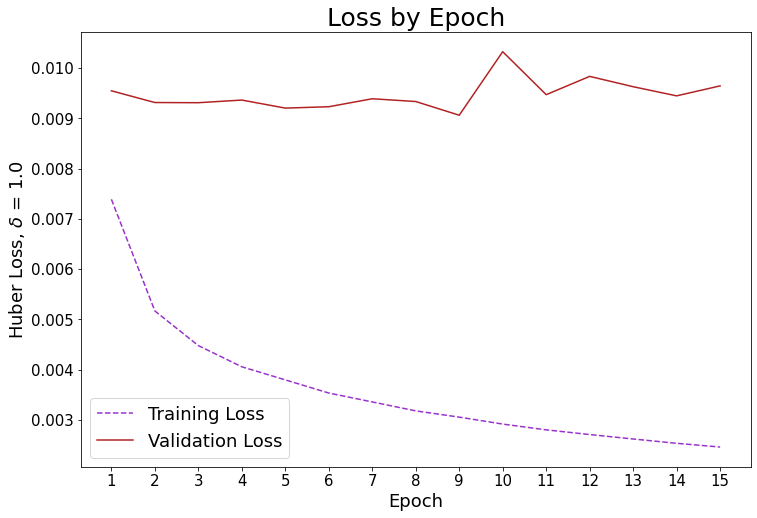

In [9]:
plot_loss(history_model_huber_15, 'Huber')
plt.savefig('../charts/huber_loss_per_epoch.png')

Loss by Epoch plot of Huber Loss Function with delta = 1.0 for 15 epochs of training in the NVIDIA model architecture. Clearly Epoch 9 was the best as the loss slowly started to increase for later epochs. The training data used for this run was collected by the team.

We also explored in details how our data were transformed by the filter layters of the convolutional model to have a better understanding of how our model works. Below is an example of the feature maps after filter on our third convolutional layer. We can see that the model itself is able to detect the road features on its own even on roads without lane marks, which is quite impressive and shows that this model could be more efficient compared to complex ones.

In [4]:
# Load model
#loaded_model_huber = load_model('./model_15_epochs.h5')
loaded_model_huber = load_model('../assets/model-huber.h5')
# Display summary of model to check tha this is the correct model
loaded_model_huber.summary()

ValueError: bad marshal data (unknown type code)

In [5]:
# summarize filter dimensions
for layer in loaded_model_huber.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer, layer.name, filters.shape)
    
# summarize feature map dimensions
for i in range(len(loaded_model_huber.layers)):
    layer = loaded_model_huber.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

NameError: name 'loaded_model_huber' is not defined

In [ ]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [ ]:
# plot first few filters
n_filters, ix = 24, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix, fc='grey')
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            c = '\nRED'
        elif j == 1:
            c = '\nGREEN'
        else:
            c ='\nBLUE'
        plt.xlabel(xlabel=c,color='w')
        plt.ylabel(ylabel=f'  \n\n{i+1}',color='w',rotation=0)
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1

# Output: Activation following 1st Conv2D layer
layer_2 = tf.keras.Model(inputs=loaded_model_huber.inputs, outputs=loaded_model_huber.layers[5].output)

In [ ]:
# load the image with the required shape & add channels (3-RGB)
img_path = '../../../../Desktop/dsi/projects/IMG/center_2020_11_08_19_20_22_873.jpg'

# convert the image to an array
img = img_to_array(load_img(img_path, target_size=(160, 320)))

# expand dimensions so that it represents a single 'sample'
print(img.shape)
img = np.expand_dims(img, axis=0)
print(img.shape)

# get feature map for first hidden layer
feature_maps = layer_2.predict(img)

# plot all 64 maps in an 8x8 squares
row = 8
col = 8
d = 1
for _ in range(row):
    for _ in range(col):
        # specify subplot and turn of axis
        ax = plt.subplot(row, col, d)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, d-1], cmap='gray')
        d += 1

<td><img src='../charts/feature_maps_conv2D_layer01.png' alt="Drawing" style="width: 500px;"/></td>
<td><img src='../charts/feature_maps_conv2D_layer02.png' alt="Drawing" style="width: 500px;"/></td>
<td><img src='../charts/feature_maps_conv2D_layer03.png' alt="Drawing" style="width: 500px;"/></td>
<td><img src='../charts/feature_maps_conv2D_layer04.png' alt="Drawing" style="width: 500px;"/></td>
<td><img src='../charts/feature_maps_conv2D_layer05.png' alt="Drawing" style="width: 500px;"/></td>